# Лабораторна робота №3 "Unsupervised Learning"
---
Виконав: студент III курсу групи ДА-12 **Чернишов Михайло Олександрович**

### Мета
Навчитись робити передобробку даних та використовувати інструменти для кластеризації (Unsupervised Learning).
### Завдання
1. Прочитати опис та викачати дані з Kaggle змагання https://www.kaggle.com/c/titanic/data .
2. Обробити дані для подальшого використання у кластеризації (вирішити проблему з missing data, закодувати змінні).
3. Провести кластеризацію даних за допомогою алгоритмів кластеризації з різними параметрами.
4. Візуалізувати та оформити результати.

## Хід роботи
Імпорт необхідних модулів
___

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

Завантаження даних
___

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

Знайдемо розмір датасетів та виведемо 5 випадкових рядків з кожного
___

**Train dataset**

In [3]:
data_train.shape

(891, 12)

In [4]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
663,664,0,3,"Coleff, Mr. Peju",male,36.0,0,0,349210,7.4958,NaN,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,330958,7.8792,NaN,Q
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,NaN,S


**Test dataset**

In [5]:
data_test.shape

(418, 11)

In [6]:
data_test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
40,932,3,"Karun, Mr. Franz",male,39.00,0,1,349256,13.4167,NaN,C
57,949,3,"Abelseth, Mr. Olaus Jorgensen",male,25.00,0,0,348122,7.6500,F G63,S
281,1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
123,1015,3,"Carver, Mr. Alfred John",male,28.00,0,0,392095,7.2500,NaN,S
191,1083,1,"Salomon, Mr. Abraham L",male,NaN,0,0,111163,26.0000,NaN,S


Бачимо, що стовпці "Name", "PassengerID", "Ticket" та "Cabin" містять унікальні значення для кожного пасажира та наврядчи матимуть суттєвий вплив на результат кластеризації, тому видалимо їх з обох датасетів:
___

In [7]:
data_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis=1, inplace=True)
data_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

Знайдемо кількість відсутніх значень у кожному стовпці. Для цього реалізуємо відповідну функцію
___

In [8]:
def missing_values_info(data):
    res = pd.DataFrame((data.isnull().sum()).sort_values(ascending=False))
    res.columns = ['Number of missing values']
    return res

**Train dataset**

In [9]:
missing_values_info(data_train)

,Number of missing values
Age,177
Embarked,2
Pclass,0
Sex,0
SibSp,0
Parch,0
Fare,0


**Test dataset**

In [10]:
missing_values_info(data_test)

,Number of missing values
Age,86
Fare,1
Pclass,0
Sex,0
SibSp,0
Parch,0
Embarked,0


Заповнимо відсутні значення
___

In [11]:
train_age_median = data_train['Age'].median()
test_age_median = data_test['Age'].median()

data_train.fillna({'Age': train_age_median}, inplace=True)
data_test.fillna({'Age': test_age_median}, inplace=True)

test_fare_median = data_test['Fare'].median()

data_test.fillna({'Fare': test_fare_median}, inplace=True)

train_embarked_median = data_train['Embarked'].mode()[0]
test_embarked_median = data_test['Embarked'].mode()[0]

data_train.fillna({'Embarked': train_embarked_median}, inplace=True)
data_test.fillna({'Embarked': test_embarked_median}, inplace=True)

Переконаємося, що відсутні значення заповнено:
___

**Train dataset**

In [12]:
missing_values_info(data_train)

,Number of missing values
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


**Test dataset**

In [13]:
missing_values_info(data_test)

,Number of missing values
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


Визначимо типи змінних датасетів
___

**Train dataset**

In [14]:
data_train.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

**Test dataset**

In [15]:
data_test.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

Закодуємо категоріальні змінні в числові значення. Для категоріальних змінних з 2 унікальними категоріями (Sex) використаємо label кодування, з більш ніж 2 унікальними категоріями (Emarked) – one-hot кодування
___

In [16]:
le = LabelEncoder()
data_train["Sex"]= le.fit_transform(data_train["Sex"])
data_test["Sex"]= le.transform(data_test["Sex"])

data_train = pd.get_dummies(data_train, columns=['Embarked'])
data_test = pd.get_dummies(data_test, columns=['Embarked'])

Використовуючи різну кількість кластерів проведемо кластеризацію даних за допомогою алгоритмів кластеризації.

* Agglomerative - алгоритм відноситься до сімейства ієрархічних кластерних алгоритмів, де об'єкти групуються в підмножини (кластери) на основі схожості між ними. Алгоритм починає роботу з того, що кожен об'єкт сприймається як окремий кластер. Потім він послідовно об'єднує найближчі кластери, поки не досягне заданого критерію зупинки.

* KMEANS - даний алгоритм ділить набір даних на k кластерів. Основна ідея полягає в тому, щоб ітеративно групувати точки даних разом таким чином, щоб мінімізувати суму квадратів відстаней між точками даних і призначеними центроїдами кластера.


* Gaussian Mixture Model (GMM) - це статистична модель, яка вважає, що дані в кожному кластері розподілені за допомогою кількох гаусівських розподілів. Таким чином, алгоритм моделює кожен кластер як суму декількох гаусівських розподілів.
___

In [17]:
def clustering_algo(strategy, cluster_count, pca_training_data, pca_testing_data):
    clustering_model = None
    training_predictions = None
    testing_predictions = None

    if strategy == 'KMEANS':
        clustering_model = KMeans(n_clusters=cluster_count, random_state=42)
        clustering_model.fit(pca_training_data)
        training_predictions = clustering_model.predict(pca_training_data)
        testing_predictions = clustering_model.predict(pca_testing_data)

    elif strategy == 'AGGLOMERATIVE':
        clustering_model = AgglomerativeClustering(n_clusters=cluster_count)
        clustering_model.fit(pca_training_data)
        training_predictions = clustering_model.labels_
        testing_predictions = clustering_model.fit_predict(pca_testing_data)

    elif strategy == 'GAUSSIAN_MIXTURE':
        clustering_model = GaussianMixture(n_components=cluster_count, random_state=42)
        clustering_model.fit(pca_training_data)
        training_predictions = clustering_model.predict(pca_training_data)
        testing_predictions = clustering_model.predict(pca_testing_data)

    else:
        print('Invalid clustering method specified')

    return training_predictions, testing_predictions


Для перевірки ефективності моделей, реалізуємо візуалізацію кластерів, а також оцінимо *silhouette score*.

*silhouette score* - це показник, який вимірює наскільки добре кожна точка даних вписується в призначений їй кластер. Оцінка, ближча до 1, вказує на те, що точка даних добре відповідає своєму кластеру, а оцінка, ближча до -1, вказує на те, що точка даних може краще підходити до іншого кластера.

Проаналізуємо алгоритми на різній кількості кластерів та виведемо графіки залежності оцінки *silhouette score* від кількості кластерів.
___

In [18]:
def execute_clustering(strategy):
    pca_processor = PCA(n_components=2)
    pca_train = pca_processor.fit_transform(data_train)
    pca_test = pca_processor.transform(data_test)
    scores_train = []
    scores_test = []

    figure, plot_axes = plt.subplots(nrows=2, ncols=9, figsize=(25, 10))
    plot_axes = plot_axes.ravel()

    for num_clusters in range(2, 11):
        predicted_train, predicted_test = clustering_algo(strategy, num_clusters, pca_train, pca_test)

        score_train = silhouette_score(pca_train, predicted_train)
        score_test = silhouette_score(pca_test, predicted_test)

        scores_train.append(score_train)
        scores_test.append(score_test)

        plot_ax = plot_axes[num_clusters - 2]
        plot_ax.scatter(pca_train[:, 0], pca_train[:, 1], c=predicted_train, s=50, cmap='viridis')
        plot_ax.set_title(f'{num_clusters} clusters\n'
                          f'train silhouette score: {score_train:.2f}\n'
                          f'test silhouette score: {score_test:.2f}\n'
                          f'\n'
                          f'train')

        plot_ax = plot_axes[num_clusters + 7]
        plot_ax.scatter(pca_test[:, 0], pca_test[:, 1], c=predicted_test, s=50, cmap='viridis')
        plot_ax.set_title(f'test')

    print(f'\n\n {strategy} clustering\n')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(range(2, 11), scores_train, 'o-', color='#008080', label='Train')
    plt.plot(range(2, 11), scores_test, 'o-', color='purple', label='Test')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.show()

**K-MEANS Clustering**
___



 KMEANS clustering



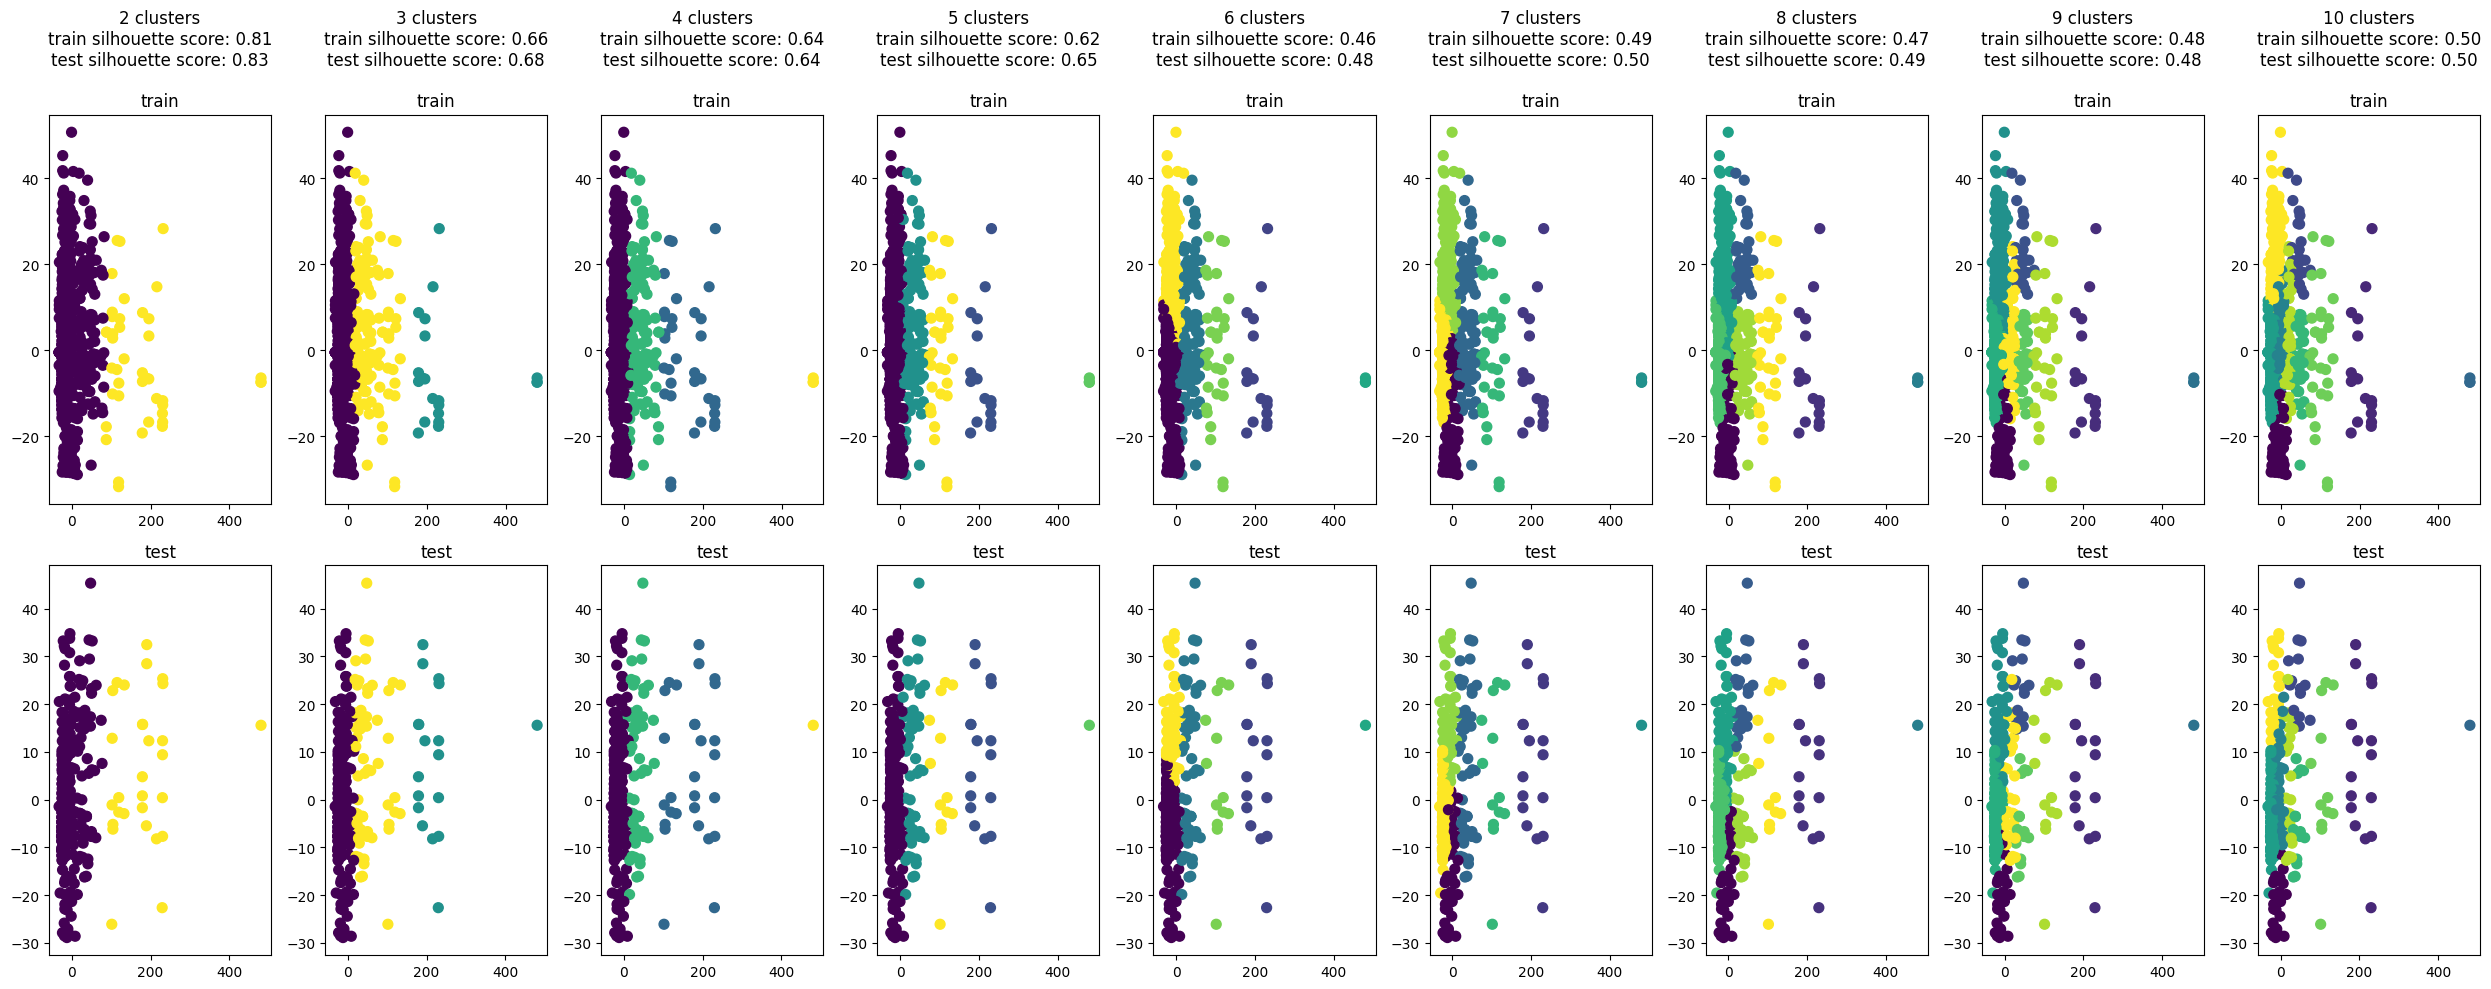

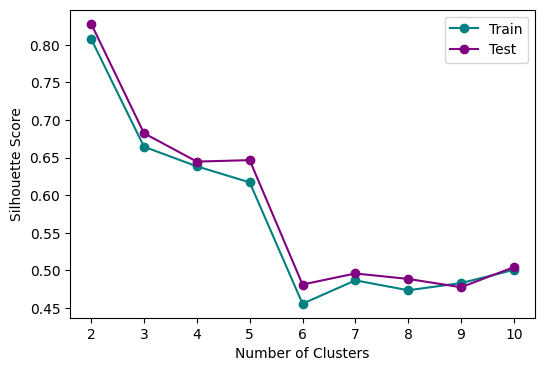

In [19]:
execute_clustering('KMEANS')

**Agglomerative Clustering**
___



 AGGLOMERATIVE clustering



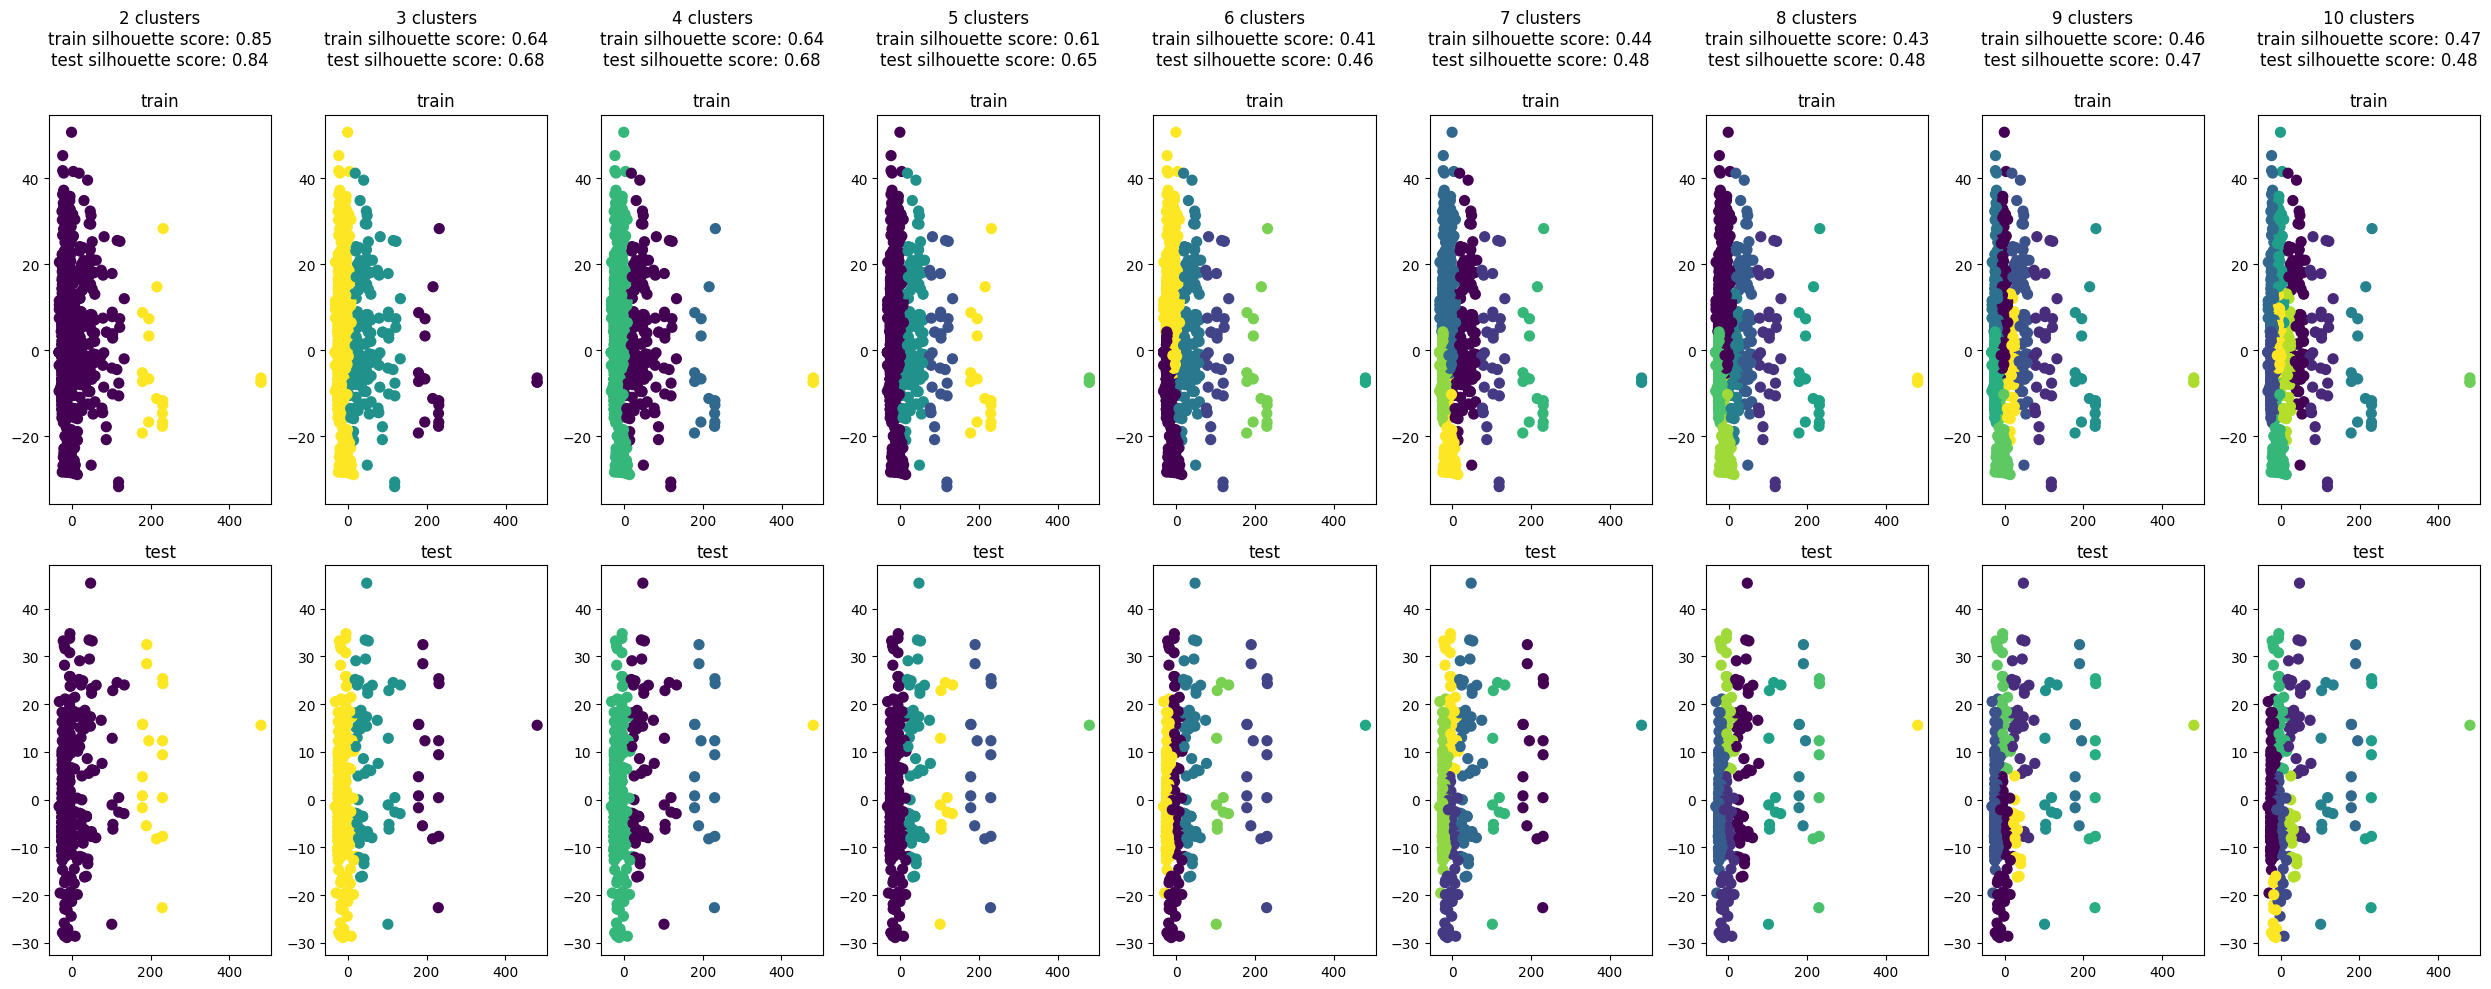

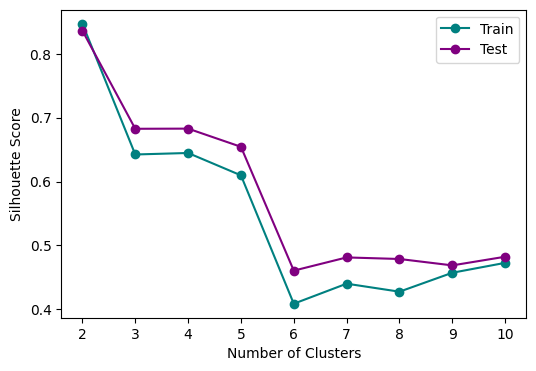

In [20]:
execute_clustering('AGGLOMERATIVE')

**Gaussian Mixture Model (GMM) Clustering**
___



 GAUSSIAN_MIXTURE clustering



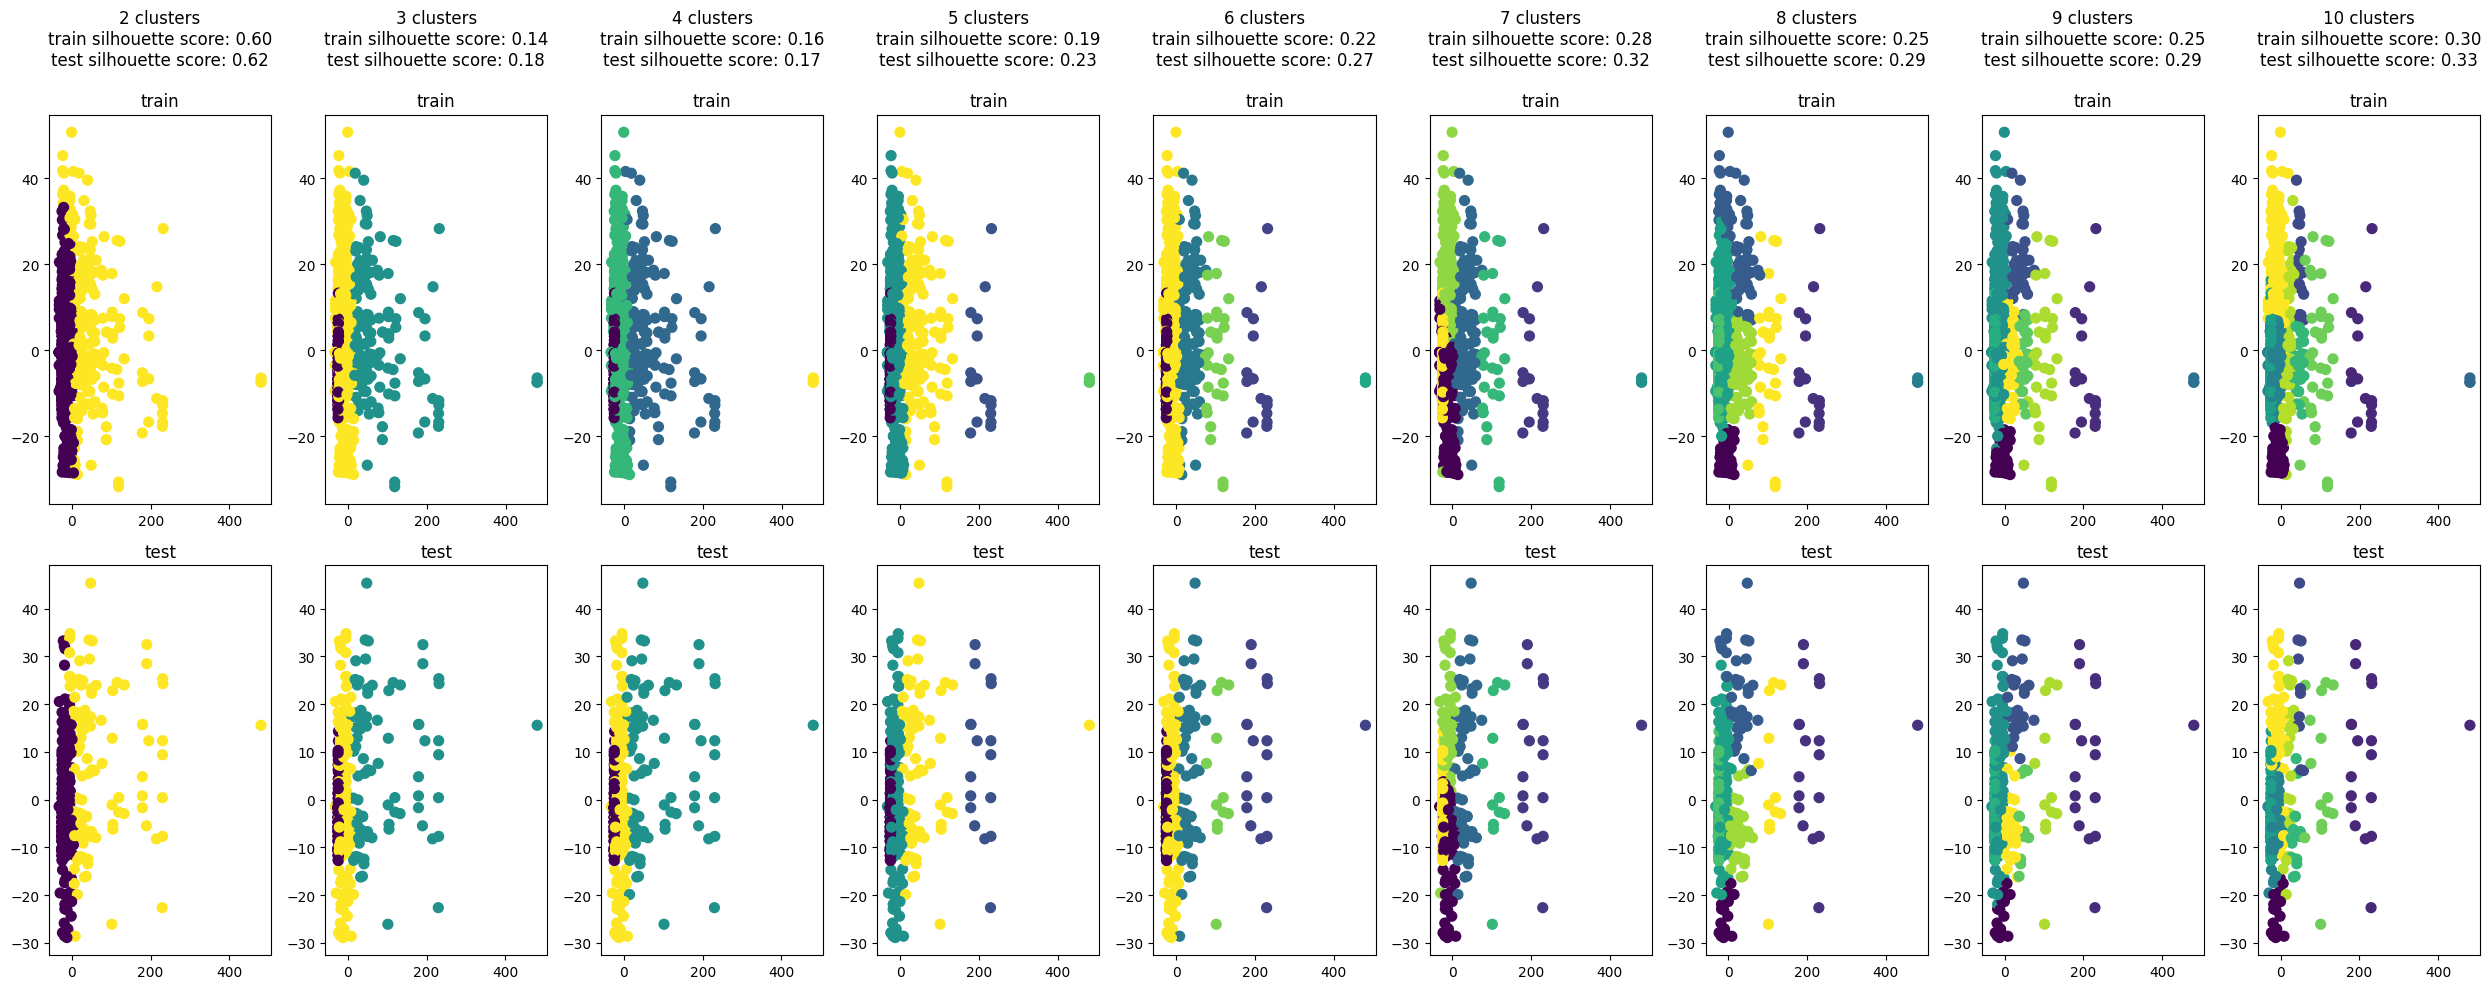

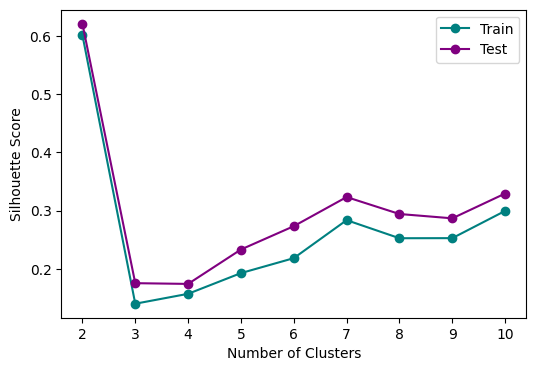

In [21]:
execute_clustering('GAUSSIAN_MIXTURE')

___
Отже, можна вказати, що ідеальна кількість кластерів залежить не лише від характеристик даних, а й від вибраного методу кластеризації.

Для методів кластеризації KMEANS та AGGLOMERATIVE найвищий *silhouette score* було отримано у діапазоні від 2 до 5 кластерів. Водночас метод GAUSSIAN MIXTURE показав найкращі результати при використанні двох кластерів. Особливо високу оцінку продемонстрував метод AGGLOMERATIVE з двома кластерами.

Некоректний вибір кількості кластерів може спотворити інтерпретацію результатів та знизити ефективність кластеризації. Зокрема, занадто велика кількість кластерів може призвести до перенавчання, коли кожен елемент аналізується як окремий кластер, що зменшує корисність кластеризації. Натомість занадто мала кількість кластерів може призвести до втрати важливих даних і взаємозв'язків між ними.